<a href="https://colab.research.google.com/github/shreyasr-upenn/asr-error-correction-cis522/blob/main/Finetune_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 522 - Final Project
### Team: Transcriptionists
Members:
Manni Arora - manni@seas.upenn.edu
Pooja Dattatri - poojadat@seas.upenn.edu
Shreyas Ramesh - shreyasr@seas.upenn.edu

### Install dependencies

In [ ]:
!git clone https://github.com/huggingface/transformers \
&& cd transformers \

Cloning into 'transformers'...
remote: Enumerating objects: 100736, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 100736 (delta 50), reused 53 (delta 44), pack-reused 100643
Receiving objects: 100% (100736/100736), 90.04 MiB | 31.42 MiB/s, done.
Resolving deltas: 100% (73859/73859), done.


In [ ]:
!pip install -q ./transformers
!pip install datasets
!pip install jiwer

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 77 kB 3.3 MB/s 
     |████████████████████████████████| 895 kB 32.3 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
     |████████████████████████████████| 6.6 MB 60.2 MB/s 
     |████████████████████████████████| 325 kB 5.1 MB/s 
     |████████████████████████████████| 212 kB 54.9 MB/s 
     |████████████████████████████████| 136 kB 52.8 MB/s 
     |████████████████████████████████| 1.1 MB 47.9 MB/s 
     |███████████

In [ ]:
# Imports
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

import torch
from google.colab import drive
import pandas as pd
from datasets import load_dataset
from jiwer import wer
import matplotlib.pyplot as plt


# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("prithivida/grammar_error_correcter_v1")

# Load the model
model = AutoModelForSeq2SeqLM.from_pretrained("prithivida/grammar_error_correcter_v1")
torch_device = 'cuda'

loading configuration file https://huggingface.co/prithivida/grammar_error_correcter_v1/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/4b041455c24b5464a505374e7c9680488fc2962e3fe80ec9b60be70f2c4d7ee1.dd25c393eefe4dc838609da89587e7aad89f3b1e0c88339305746378d840c072
Model config T5Config {
  "_name_or_path": "prithivida/grammar_error_correcter_v1",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "gradient_checkpointing": false,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization

### Data preparation

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
lines = open('/content/drive/Shareddrives/CIS522Project/Data/output_ami_pretrained/fine_tune_data.jsonl', encoding='utf-8').\
        read().strip().split('\n')

pairs = []

for l in lines:
  pair = l.replace('"prompt": "ASR output: ', "").replace("ASR correction: ", "").replace("\\n", "").replace("{", "").replace("}", "").replace("###", "").strip().split('", \"completion\": "')
  pair[1] = pair[1].replace('"', '')
  if pair[0] and pair[1]:
    pairs.append(pair)


In [ ]:
train_df = pd.DataFrame(pairs, columns=["ASR_output", "ASR_corrected"])
train_df.to_csv("train.csv", index=False)

In [ ]:
lines = open('/content/drive/Shareddrives/CIS522Project/Data/output_ami_pretrained/test_data.jsonl', encoding='utf-8').\
        read().strip().split('\n')

pairs = []

for l in lines:
  pair = l.replace('"prompt": "ASR output: ', "").replace("ASR correction: ", "").replace("\\n", "").replace("{", "").replace("}", "").replace("###", "").strip().split('", \"completion\": "')
  pair[1] = pair[1].replace('"', '')
  if pair[0] and pair[1]:
    pairs.append(pair)

In [ ]:
test_df = pd.DataFrame(pairs, columns=["ASR_output", "ASR_corrected"])
test_df.to_csv("test.csv", index=False)

In [ ]:
data_files = {"train": "train.csv", "test": "test.csv"}
asr_dataset = load_dataset("csv", data_files=data_files)

Using custom data configuration default-63498af57ed68646


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-63498af57ed68646/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["ASR_output"], max_length=400, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["ASR_corrected"], max_length=400, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets_input = asr_dataset.map(preprocess_function)

  0%|          | 0/12285 [00:00<?, ?ex/s]

  0%|          | 0/21670 [00:00<?, ?ex/s]

In [ ]:
tokenized_datasets_input

DatasetDict({
    train: Dataset({
        features: ['ASR_output', 'ASR_corrected', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12285
    })
    test: Dataset({
        features: ['ASR_output', 'ASR_corrected', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 21670
    })
})

### Finetune Model

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=7)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_input["train"],
    eval_dataset=tokenized_datasets_input["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: ASR_output, ASR_corrected. If ASR_output, ASR_corrected are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 12285
  Num Epochs = 7
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10752


Epoch,Training Loss,Validation Loss
1,0.994400,1.002783
2,0.875400,0.971717
3,0.807300,0.957746
4,0.738300,0.958904
5,0.702800,0.964476
6,0.646300,0.965369
7,0.642800,0.966404


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-1500/tokenizer_config.json
Special tokens file saved

TrainOutput(global_step=10752, training_loss=0.7809778920241764, metrics={'train_runtime': 2676.85, 'train_samples_per_second': 32.125, 'train_steps_per_second': 4.017, 'total_flos': 2797556117345280.0, 'train_loss': 0.7809778920241764, 'epoch': 7.0})

In [ ]:
epoch = [i for i in range(1, 8)]
training_loss = [0.9944, 0.8754, 0.8073, 0.7383, 0.7028, 0.6463, 0.6428]
validation_loss = [1.0027, 0.9717, 0.9577, 0.9589, 0.9644, 0.9653, 0.9664]

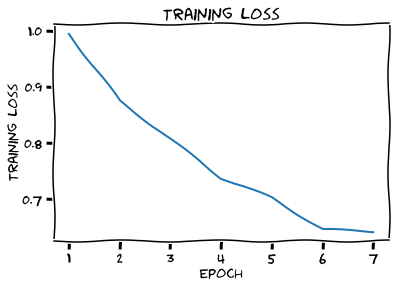

In [ ]:
with plt.xkcd():
    plt.plot(epoch, training_loss, linewidth=2)
    plt.title('Training loss')
    plt.ylabel('Training loss')
    plt.xlabel('Epoch')
    plt.savefig('training_loss.png')
    plt.show()

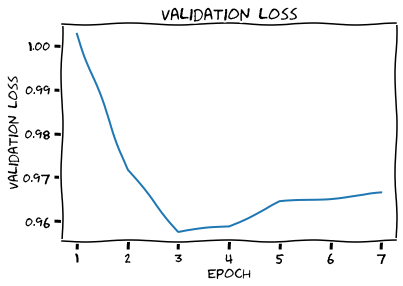

In [ ]:
with plt.xkcd():
    plt.plot(epoch, validation_loss, linewidth=2)
    plt.title('Validation loss')
    plt.ylabel('Validation loss')
    plt.xlabel('Epoch')
    plt.savefig('validation_loss.png')
    plt.show()

### Evaluation

In [ ]:
phrases = list(test_df["ASR_output"])[:100]
corrected = list(test_df["ASR_corrected"])[:100]
gold = []

# Tokenize text
tokenized_phrases = tokenizer(phrases, return_tensors='pt', padding=True, max_length=1000, truncation=True).to(torch_device)

# Perform corrections and decode the output
corrections = model.generate(**tokenized_phrases)
corrections = tokenizer.batch_decode(corrections, skip_special_tokens=True)

# Print correction
output = []
for i in range(len(corrections)):
  original, correction = phrases[i], corrections[i]
  gold.append(corrected[i][:len(correction)])
  output.append(correction)
  print(f'[ASR output] {original}')
  print(f'[Suggested correction] {correction}')
  print('~'*100)

[ASR output] m and then i'll be coming to you as the user interface person to try to tell me from your point of view what are the most friendly features that we could put on it and try to prior help me with that prioritizing of ah of the features and of the the look and the collor and i'll be coming back to you to help wead oubt those suggestions from that point of view
[Suggested correction] um and then i'll be coming to you as the user interface person to try to
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[ASR output] or the any problem is that with a mobile phone you sign for contract so they am the companies who are who you deal with hav vaty they've they've got an obligation to to help you out and also i mean it's it's fair enough to have some sort of help service but i i am not sure how much the cost would be of having
[Suggested correction] or the any problem is that with a mobile phone you sign for contract so they are th

#### WER

In [ ]:
print(round(wer(output, gold)*100, 2), "%")

25.36 %
